In [1]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import unittest
import gc

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import sys

sys.path.append('/Users/scottmerrill/Documents/UNC/Research/coingame/evoenv')
import evoenv
from evoenv.envs.coin_game import CoinGame
from evoenv.envs.enumerated_stochastic_game import EnumeratedStochasticGame, MatrixGame
from evoenv.matrixtools.matrixtools import FloatTupleDtype

from players import PPOPlayer, DQNPlayer, VPGPlayer
from population import Population
from networks import MLP, GaussianPolicy, CategoricalPolicy
from memoryBuffers import ReplayBuffer, Buffer
import coinGameExperiment
import configparser
from datetime import datetime

from cg_utils import section_to_dict, build_reward_matrix, plot_reward_hist, show_payoff_mat
from pivottablejs import pivot_ui

import ipywidgets as widgets
from IPython.display import display

### Set Main Params

In [2]:
slider_style = {'description_width': 'initial', 'handle_color': 'lightblue', 'width': '100%', 'margin': '5px 0 0 0'}

rounds = widgets.IntSlider(value=5, min=1, max=1000, step=1, description='Rounds')
rounds.style = slider_style

timesteps = widgets.IntSlider(value=100, min=1, max=1000, step=1, description='Timesteps')
timesteps.style = slider_style

count = widgets.IntSlider(value=0, min=0, max=5, step=1, description='Count')
count.style = slider_style

N = widgets.IntSlider(value=20, min=1, max=100, step=1, description='N')
N.style = slider_style

d = widgets.IntSlider(value=1, min=1, max=N.value//2, step=1, description='d')
d.style = slider_style

hidden_size_multiple = widgets.IntSlider(value=1, min=1, max=10, step=1, description='hidden_size_multiple')
hidden_size_multiple.style = slider_style

a = widgets.IntSlider(value=3, min=-100, max=100, step=1, description='a')
a.style = slider_style

b = widgets.IntSlider(value=20, min=-100, max=100, step=1, description='b')
b.style = slider_style

c = widgets.IntSlider(value=-5, min=-100, max=100, step=1, description='c')
c.style = slider_style

d2 = widgets.IntSlider(value=5, min=-100, max=100, step=1, description='d')
d2.style = slider_style

memory = widgets.IntSlider(value=1, min=1, max=5, step=1, description='memory') 
memory.style = slider_style
rewards = build_reward_matrix(a.value, b.value, c.value, d2.value)

display(rounds)
display(timesteps)
display(count)
display(N)
display(d)
display(memory)
display(hidden_size_multiple)
display(a)
display(b)
display(c)
display(d)

IntSlider(value=5, description='Rounds', max=1000, min=1, style=SliderStyle(description_width='initial', handl…

IntSlider(value=100, description='Timesteps', max=1000, min=1, style=SliderStyle(description_width='initial', …

IntSlider(value=0, description='Count', max=5, style=SliderStyle(description_width='initial', handle_color='li…

IntSlider(value=20, description='N', min=1, style=SliderStyle(description_width='initial', handle_color='light…

IntSlider(value=1, description='d', max=10, min=1, style=SliderStyle(description_width='initial', handle_color…

IntSlider(value=1, description='memory', max=5, min=1, style=SliderStyle(description_width='initial', handle_c…

IntSlider(value=1, description='hidden_size_multiple', max=10, min=1, style=SliderStyle(description_width='ini…

IntSlider(value=3, description='a', min=-100, style=SliderStyle(description_width='initial', handle_color='lig…

IntSlider(value=20, description='b', min=-100, style=SliderStyle(description_width='initial', handle_color='li…

IntSlider(value=-5, description='c', min=-100, style=SliderStyle(description_width='initial', handle_color='li…

IntSlider(value=1, description='d', max=10, min=1, style=SliderStyle(description_width='initial', handle_color…

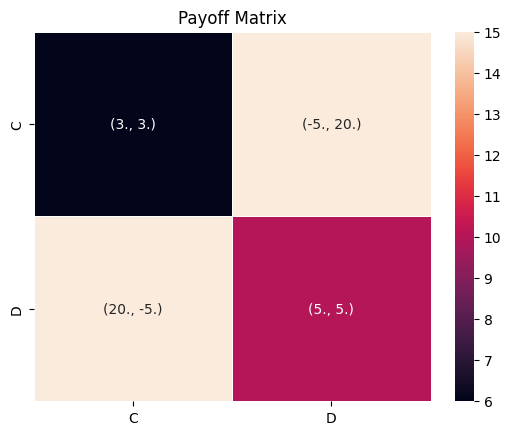

In [3]:
show_payoff_mat(rewards)

### Environment Setup

In [4]:
population_dict = {'N':N.value,
                'd':d.value}

# environment settings
state_space = 1
actions_space = 2

# players memory
players_per_game = 2

# input size, we need an additional state for every memory lookback
# we also are appending to the state each players action
input_size = state_space + (state_space + players_per_game*actions_space) * (memory.value)

rewards = build_reward_matrix(a.value, b.value, c.value, d2.value)
env = MatrixGame
env_options = {'rewards':rewards}


# two states, but returned as a single scalar (0 or 1), two actions
env_description = {'obs_dim':input_size,
                   'act_dim':actions_space,
                   'act_limit':1}

env_dict = {'env':env,
            'env_options':env_options,
            'env_description':env_description}

### Player Setup

In [5]:
# player settings
base_player_options = {'memory':memory.value}

### VPG

In [6]:
config_file_path = 'configs/VPG.ini' 
config = configparser.ConfigParser()
config.read(config_file_path)

vpg_models = [section_to_dict(config, 'models'), section_to_dict(config, 'models')]

actor_config = section_to_dict(config, 'actor_config')
critic_config = section_to_dict(config, 'critic_config')

actor_config['input_size'] = input_size
actor_config['hidden_sizes'] = (hidden_size_multiple.value*input_size,)
actor_config['output_size'] = int(actions_space)

critic_config['input_size'] = input_size
critic_config['output_size'] = int(1)
critic_config['hidden_sizes'] = (hidden_size_multiple.value*input_size,)

vpg_model_params = [actor_config, critic_config]

vpg_player_options = section_to_dict(config, 'learning_params')
vpg_player_options['sample_size'] = timesteps.value

vpg_player_dict = {'player_class':VPGPlayer,
               'memory':memory.value,
               'base_player_options':base_player_options,
               'additional_player_options':vpg_player_options,
               'player_models':vpg_models,
               'player_model_params':vpg_model_params}

### PPO

In [7]:
config_file_path = 'configs/PPO.ini' 
config = configparser.ConfigParser()
config.read(config_file_path)

ppo_models = [section_to_dict(config, 'models'), section_to_dict(config, 'models')]

actor_config = section_to_dict(config, 'actor_config')
critic_config = section_to_dict(config, 'critic_config')

actor_config['input_size'] = input_size
actor_config['hidden_sizes'] = (hidden_size_multiple.value*input_size,)
actor_config['output_size'] = int(actions_space)

critic_config['input_size'] = input_size
critic_config['output_size'] = int(1)
critic_config['hidden_sizes'] = (4*input_size,)
ppo_model_params = [actor_config, critic_config]

ppo_player_options = section_to_dict(config, 'learning_params')
ppo_player_options['sample_size'] = timesteps.value # train after each round

ppo_player_dict = {'player_class':PPOPlayer,
                   'memory':memory.value,
                   'base_player_options':base_player_options,
                   'additional_player_options':ppo_player_options,
                   'player_models':ppo_models,
                   'player_model_params':ppo_model_params}

### DQN

In [8]:
config_file_path = 'configs/DQN.ini' 
config = configparser.ConfigParser()
config.read(config_file_path)

dqn_model = [section_to_dict(config, 'models')]

dqn_model_params = section_to_dict(config, 'model_params')

dqn_model_params['input_size'] = input_size
dqn_model_params['hidden_sizes'] = (4*input_size,)
dqn_model_params['output_size'] = int(actions_space)

dqn_player_options = section_to_dict(config, 'learning_params')
dqn_player_options['target_update_step'] = timesteps.value # update after each round

dqn_player_dict = {'player_class':DQNPlayer,
                   'memory':memory.value,
               'base_player_options':base_player_options,
               'additional_player_options':dqn_player_options,
               'player_models':dqn_model,
               'player_model_params':[dqn_model_params]}

### Run Experiments

#### VPG

In [9]:
experiment = coinGameExperiment.CoinGameExperiment(env_dict=env_dict,
                                                   population_dict=population_dict,
                                                   player_dict=vpg_player_dict,
                                                   device=device,
                                                   save_path=None)

print(f'Starting timesteps:{timesteps.value}, rounds:{rounds.value}, N:{N.value}, d:{d.value}, VPG')
start = datetime.now()
print(start)
vpg_df, vpg_players, vpg_players_df = experiment.play_multi_rounds(rounds.value, timesteps.value, count.value)
print(datetime.now()-start)
del experiment
gc.collect()

Starting timesteps:100, rounds:5, N:20, d:1, VPG
2023-10-30 13:06:51.978535
Round 0, Start Time 2023-10-30 13:06:51.981701
Round 0, Total Time 0:00:00.001243, Time/Game: 0:00:00.000124, Time/timestep: 0:00:00.000001
Round 1, Start Time 2023-10-30 13:06:55.012577
Round 1, Total Time 0:00:00.000859, Time/Game: 0:00:00.000086, Time/timestep: 0:00:00.000001
Round 2, Start Time 2023-10-30 13:06:57.718220
Round 2, Total Time 0:00:00.000667, Time/Game: 0:00:00.000067, Time/timestep: 0:00:00.000001
Round 3, Start Time 2023-10-30 13:07:00.406028
Round 3, Total Time 0:00:00.000638, Time/Game: 0:00:00.000064, Time/timestep: 0:00:00.000001
Round 4, Start Time 2023-10-30 13:07:03.303242
Round 4, Total Time 0:00:00.000455, Time/Game: 0:00:00.000046, Time/timestep: 0:00:00
0:00:14.304979


0

#### DQN

In [ ]:
experiment = coinGameExperiment.CoinGameExperiment(env_dict=env_dict,
                                                   population_dict=population_dict,
                                                   player_dict=dqn_player_dict,
                                                   device=device,
                                                   save_path=None)

print(f'Starting timesteps:{timesteps.value}, rounds:{rounds}, N:{N}, d:{d}, VPG')
start = datetime.now()
print(start)
dqn_df, dqn_players, dqn_players_df = experiment.play_multi_rounds(rounds.value, timesteps.value, count.value)
print(datetime.now()-start)
del experiment
gc.collect()

Starting timesteps:100, rounds:IntSlider(value=5, description='Rounds', max=1000, min=1, style=SliderStyle(description_width='initial', handle_color='lightblue')), N:IntSlider(value=20, description='N', min=1, style=SliderStyle(description_width='initial', handle_color='lightblue')), d:IntSlider(value=1, description='d', max=10, min=1, style=SliderStyle(description_width='initial', handle_color='lightblue')), VPG
2023-10-30 13:07:06.390823
Round 0, Start Time 2023-10-30 13:07:06.391241
Round 0, Total Time 0:00:00.000384, Time/Game: 0:00:00.000038, Time/timestep: 0:00:00
Round 1, Start Time 2023-10-30 13:07:08.458570
Round 1, Total Time 0:00:00.000774, Time/Game: 0:00:00.000077, Time/timestep: 0:00:00.000001
Round 2, Start Time 2023-10-30 13:07:11.566665


#### PPO

In [ ]:
experiment = coinGameExperiment.CoinGameExperiment(env_dict=env_dict,
                                                   population_dict=population_dict,
                                                   player_dict=ppo_player_dict,
                                                   device=device,
                                                   save_path=None)

print(f'Starting timesteps:{timesteps.value}, rounds:{rounds}, N:{N}, d:{d}, VPG')
start = datetime.now()
print(start)
ppo_df, ppo_players, ppo_players_df = experiment.play_multi_rounds(rounds.value, timesteps.value, count.value)
print(datetime.now()-start)
del experiment
gc.collect()

### Reward Hist 

In [ ]:
plot_reward_hist([ppo_df, vpg_df, dqn_df], ['PPO', 'VPG', 'DQN'])

### Pivot Tables

In [ ]:
pivot_ui(ppo_df)

In [ ]:
pivot_ui(vpg_df)

In [ ]:
pivot_ui(dqn_df)

In [ ]:
### analyze 

In [ ]:
player = ppo_players[1]